<a href="https://colab.research.google.com/github/aixuedegege/ChatBotCourse/blob/master/fine_tuning_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# 本文代码全部参考：http://mccormickml.com/2019/07/22/BERT-fine-tuning/

In [0]:
import tensorflow as tf

In [52]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [53]:
!pip install pytorch-pretrained-bert pytorch-nlp

In [54]:
tf.__version__

'1.15.0-rc3'

In [0]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [56]:
 torch.cuda.is_available()

True

In [57]:
# In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla K80'

In [0]:
# Load Dataset
# 数据有4列：
# Column 1: the code representing the source of the sentence.

# Column 2: the acceptability judgment label (0=unacceptable, 1=acceptable).

# Column 3: the acceptability judgment as originally notated by the author.

# Column 4: the sentence.
# from google.colab import files
# uploaded = files.upload()


In [0]:
df = pd.read_csv("in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

In [59]:
df.sample(10)

,sentence_source,label,label_notes,sentence
7787,ad03,1,NaN,we believed him to be the headmaster
4570,ks08,0,*,a medal was been given to the mayor by the sew...
308,cj99,0,??,this is the problem that you 'll beat the comp...
1321,r-67,1,NaN,who ate what ?
7164,sks13,1,NaN,this girl in the red coat will eat her breakfa...
5121,ks08,1,NaN,he put the money where lee told him to put it .
228,cj99,1,NaN,"once janet left , fred became far crazier ."
4511,ks08,1,NaN,are you studying english syntax ?
741,bc01,0,*,he impresses his friends all as pompous .
2713,l-93,1,NaN,nora pushed on the chair .


In [0]:
# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

In [61]:
sentences

["[CLS] our friends wo n't buy this analysis , let alone the next one we propose . [SEP]",
 "[CLS] one more pseudo generalization and i 'm giving up . [SEP]",
 "[CLS] one more pseudo generalization or i 'm giving up . [SEP]",
 '[CLS] the more we study verbs , the crazier they get . [SEP]',
 '[CLS] day by day the facts are getting murkier . [SEP]',
 "[CLS] i 'll fix you a drink . [SEP]",
 '[CLS] fred watered the plants flat . [SEP]',
 '[CLS] bill coughed his way out of the restaurant . [SEP]',
 "[CLS] we 're dancing the night away . [SEP]",
 '[CLS] herman hammered the metal flat . [SEP]',
 '[CLS] the critics laughed the play off the stage . [SEP]',
 '[CLS] the pond froze solid . [SEP]',
 '[CLS] bill rolled out of the room . [SEP]',
 '[CLS] the gardener watered the flowers flat . [SEP]',
 '[CLS] the gardener watered the flowers . [SEP]',
 '[CLS] bill broke the bathtub into pieces . [SEP]',
 '[CLS] bill broke the bathtub . [SEP]',
 '[CLS] they drank the pub dry . [SEP]',
 '[CLS] they dran

In [62]:
# 接下来，导入BERT标记器，用于将文本转换为与BERT词汇表对应的标记。
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['[CLS]', 'our', 'friends', 'wo', 'n', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']


In [0]:
# BERT需要特定格式的输入。对于每个标记化的输入语句，我们需要创建:
# input ids: 在BERT词汇表中，将每个输入记号标识为其索引号的整数序列
# segment mask: (optional) a sequence of 1s and 0s used to identify whether the input is one sentence or two sentences long. For one sentence inputs, this is simply a sequence of 0s. 
#                For two sentence inputs, there is a 0 for each token of the first sentence, followed by a 1 for each token of the second sentence
# attention mask: (optional) a sequence of 1s and 0s, with 1s for all input tokens and 0s for all padding tokens (we’ll detail this in the next paragraph)
# labels: a single value of 1 or 0. In our task  1表示“合乎语法的”，0表示“不合语法的”

In [0]:
# 虽然我们可以有可变长度的输入语句，但是BERT要求我们的输入数组大小相同。我们首先选择一个最大的句子长度，然后填充和截断输入，直到每个输入序列的长度相同。
# 如果一个句子比最大的句子长度短，我们只需在序列的末尾添加0，直到它是最大的句子长度。
# 如果一个句子比最大的句子长度长，那么我们简单地截断序列的末尾

In [0]:
# Set the maximum sequence length. 我们的训练集中最长的序列是47，但是我们还是要在最后留点空间。 
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

In [0]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [0]:
# Pad our input tokens
# “post”表示我们希望在序列的末尾进行填充和截断，而不是在序列的开头
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post") 

In [0]:
# Create the attention masks
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [0]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [0]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [0]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [0]:
# huggingface pytorch实现包括一组为各种NLP任务设计的接口。虽然这些接口都构建在经过训练的BERT模型之上，但是每个接口都有不同的顶层和输出类型，以适应其特定的NLP任务。
# 加载BertForSequenceClassification，这是普通的BERT模型，上面添加了一个线性层用于分类，我们将使用它作为句子分类器。


In [0]:
# Structure of Fine-Tuning Model
# 每个序列的第一个标记是特殊分类标记([CLS])。与普通单词标记对应的隐藏状态向量不同，
# 这个特殊标记对应的隐藏状态由BERT的作者指定为用于分类任务的整个句子的聚合表示。
# 因此，当我们在训练过程中将一个输入语句输入到我们的模型中时，输出的长度是与这个令牌对应的768隐藏状态向量。
# 我们添加的附加层顶部由未经训练的大小[hidden_state, number_of_labels]的线性神经元,所以[768,2],这意味着bert加上分类层的输出是一个向量的两个数字代表“分数”“grammatical/ non-grammatical”,然后输入叉损失。

# The Fine-Tuning Proces
# need to train the top layer, with a bit of tweaking going on in the lower levels to accomodate our task.



In [0]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

In [73]:
# 从存储的模型中获取训练超参数。
# 为了进行微调，作者推荐以下超参数范围:批大小:16,32;学习率(Adam): 5e-5, 3e-5, 2e-5;epoch数量:2,3,4

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)


t_total value of -1 results in schedule not being applied


In [0]:
param_optimizer

In [0]:
# 训练循环:
# 通过在训练模式中设置模型，让模型计算梯度，
# 解出数据输入和标签
# 加载数据解压到GPU上进行加速
# 清除上一遍计算出的梯度。在pytorch渐变积累在默认情况下(比如RNNs有用),除非你显式地清除他们
# Forward传递(输入数据通过网络)
# 向后传递(反向传播)
# 告诉网络更新参数与optimizer.step()
# 跟踪监测progress

# Evalution循环
# 告诉模型来计算梯度通过设置evaluation mode
# 解压我们的数据输入和标签
# 加载数据到GPU的加速
# Forward pass
# 计算验证数据的损失，跟踪变量以监控进展

In [0]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [77]:
t =None # Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.5086342413519428



Epoch:  25%|██▌       | 1/4 [06:23<19:10, 383.49s/it]

Validation Accuracy: 0.7943672839506173
Train loss: 0.27613331848964157



Epoch:  50%|█████     | 2/4 [12:46<12:46, 383.29s/it]

Validation Accuracy: 0.8198302469135803
Train loss: 0.12553753989798894



Epoch:  75%|███████▌  | 3/4 [19:09<06:23, 383.18s/it]

Validation Accuracy: 0.8217592592592593
Train loss: 0.07849335455996491



Epoch: 100%|██████████| 4/4 [25:31<00:00, 383.01s/it]


Validation Accuracy: 0.8198302469135803


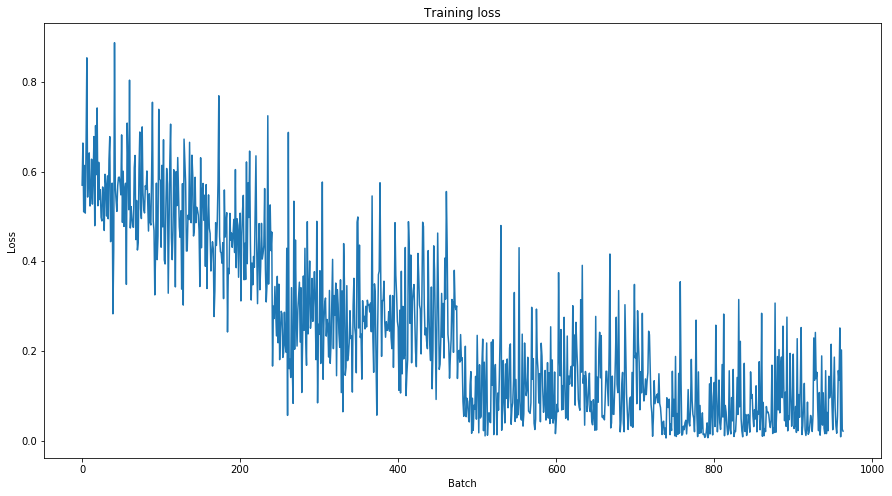

In [78]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [0]:
# 现在，我们将加载holdout数据集并准备输入，就像我们对训练集所做的那样。然后，我们将使用Matthew的相关系数来评估预测，因为这是更广泛的NLP社区用来评估CoLA性能的指标。
# 在这个度量中，1是最好的分数，-1是最差的分数。通过这种方式，我们可以看到我们在针对这个特定任务的最先进模型的状态下执行得有多好。

In [81]:
# Upload the test file from your local drive
from google.colab import files
uploaded = files.upload()

Saving out_of_domain_dev.tsv to out_of_domain_dev.tsv


In [0]:
df = pd.read_csv("out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [0]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [84]:
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [0]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]


In [87]:
matthews_corrcoef(flat_true_labels, flat_predictions)

0.4941518925689932

In [0]:
# 可在https://gluebenchmark.com/leaderboard/submission/zlssuBTm5XRs0aSKbFYGVIVdvbj1/-LhijX9VVmvJcvzKymxy 查看最新的得分